In [54]:
from pathlib import Path
import os
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# %pip install scikit-learn
from sklearn.model_selection import train_test_split
from pathlib import Path
# %pip install matplotlib
import matplotlib.pyplot as plt
import glob
import random
from PIL import Image
import numpy as np

# Larger CNN Model
import numpy as np
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from keras.layers import Normalization
from keras.models import Model  # Import Model class
from keras.layers import Input, Dense, Flatten
from keras.optimizers import SGD  # Import optimizer if not already imported


In [55]:
pixel = 37

In [56]:
train_data = tf.keras.preprocessing.image_dataset_from_directory(directory='./Dataset for CA1 part A - AY2425S1/train', 
                                                                 color_mode='grayscale', 
                                                                 batch_size=10000,
                                                                 image_size=(pixel, pixel),
                                                                 seed = 42)

Found 9043 files belonging to 15 classes.


In [57]:
test_data = tf.keras.preprocessing.image_dataset_from_directory(directory='./Dataset for CA1 part A - AY2425S1/test',
                                                                color_mode='grayscale',
                                                                batch_size=10000,
                                                                image_size=(pixel, pixel),
                                                                seed = 42)

Found 3000 files belonging to 15 classes.


In [58]:
valdation_data = tf.keras.preprocessing.image_dataset_from_directory(directory='./Dataset for CA1 part A - AY2425S1/validation',
                                                                        color_mode='grayscale',
                                                                        batch_size=10000,
                                                                        image_size=(pixel, pixel),
                                                                        seed = 42)

Found 3000 files belonging to 15 classes.


In [59]:
for image, label in train_data:
    X_train = image
    y_train = label

X_train = X_train/255
y_train = to_categorical(y_train,15)

In [60]:
for image, label in test_data:
    X_test = image
    y_test = label

X_test = X_test/255
y_test = to_categorical(y_test,15)

In [61]:
for image, label in valdation_data:
    X_validate = image
    y_validate = label

X_validate = X_validate/255
y_validate = to_categorical(y_validate,15)

In [62]:
print(X_validate.shape)
print(X_test.shape)
print(X_train.shape)    
print(y_train.shape)

(3000, 37, 37, 1)
(3000, 37, 37, 1)
(9043, 37, 37, 1)
(9043, 15)


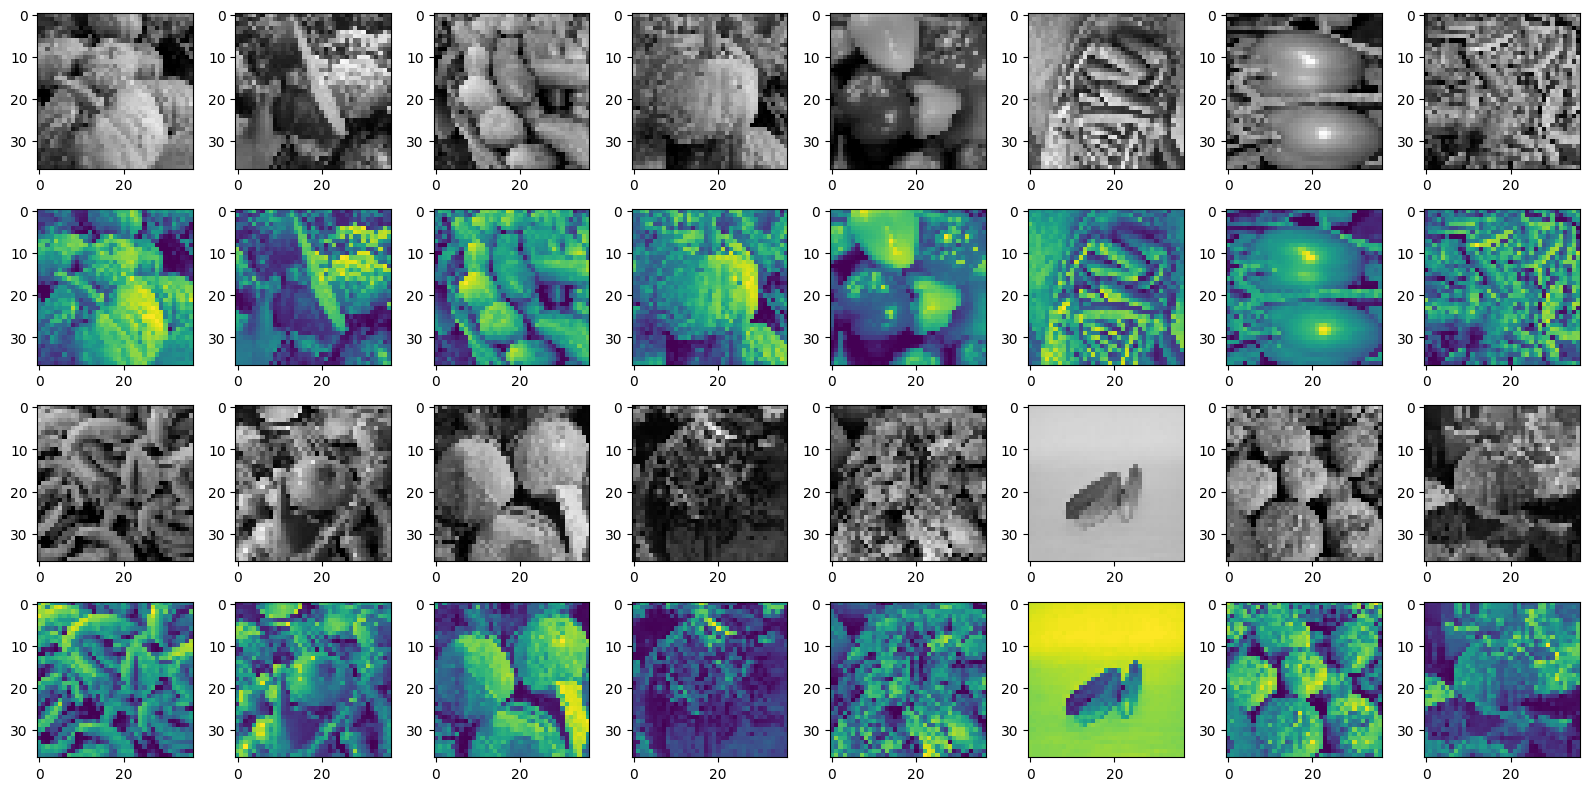

In [63]:
rows = 2 # defining number of rows in figure
cols = 8 # defining number of colums in figure

f = plt.figure(figsize=(2*cols,2*rows*2))

for i in range(rows):
    for j in range(cols):
        f.add_subplot(rows*2,cols,(2*i*cols)+(j+1))
        plt.imshow(tf.image.grayscale_to_rgb(X_train[i*cols + j]))
        plt.axis("on")

    for j in range(cols):
        f.add_subplot(rows*2,cols,((2*i+1)*cols) +(j+1))
        plt.imshow(X_train[i*cols + j])
        plt.axis("on")

plt.tight_layout()
plt.show()

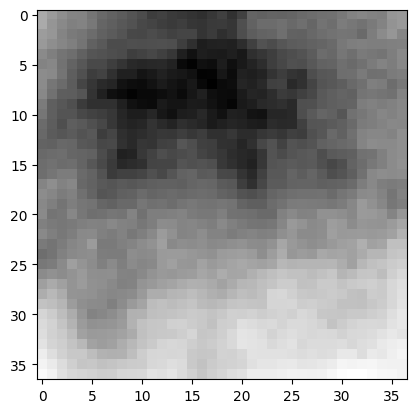

In [64]:
plt.imshow(np.mean(X_train, axis=0), cmap='Greys')
plt.show()

<Axes: >

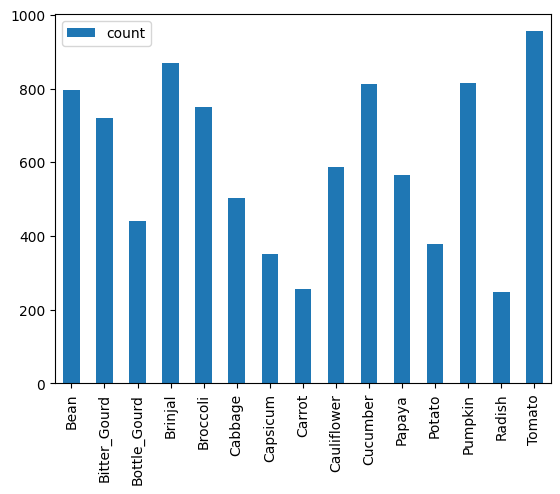

In [65]:
import pandas as pd
images_length={}
for i, cat in enumerate(os.listdir('./Dataset for CA1 part A - AY2425S1/train')):
        
        # Load images for the ith category
        image_path = "./Dataset for CA1 part A - AY2425S1/train" + '/' + cat
        images_in_folder = os.listdir(image_path)
        images_length[cat]=len(images_in_folder)
        
pd.DataFrame(images_length,index = ['count']).T.plot(kind='bar')

<h1>Utility Functions / Variable</h1>
<br>
<h1>Learning Curve Plotting Function</h1>

In [66]:
def plot_loss_curve(history):
    history = pd.DataFrame(history)
    epochs = list(range(1, len(history) + 1))
    fig, ax = plt.subplots(1, 1, figsize=(20, 10))
    plt.title("Plot Loss Curve")
    plt.scatter(epochs, history["loss"])
    plt.plot(epochs, history["loss"], label="Training Loss")
    plt.scatter(epochs, history["val_loss"])
    plt.plot(epochs, history["val_loss"], label="Validation Loss")
    plt.scatter(epochs, history["accuracy"])
    plt.plot(epochs, history["accuracy"], label="Training Accuracy")
    plt.scatter(epochs, history["val_accuracy"])
    plt.plot(epochs, history["val_accuracy"], label="Validation Accuracy")
    plt.ylabel("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

In [67]:
allResults = pd.DataFrame()

In [68]:
from sklearn import preprocessing

<h1>BaseLine Model</h1>

In [69]:
# fix random seed for reproducibility
from tensorflow.keras.layers import BatchNormalization

seed = 88
np.random.seed(seed)
# load data
num_classes = y_test.shape[1]
# build the model
# create model
model = Sequential()
model.add(Conv2D(30, (5, 5), input_shape=(37, 37, 1), activation='sigmoid'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(30, (3, 3), activation='sigmoid'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.4))
model.add(Flatten())

model.add(Dense(128, activation='sigmoid'))

model.add(BatchNormalization())
model.add(Dense(50, activation='sigmoid'))

model.add(Dense(num_classes, activation='sigmoid'))

# Compile modelZ
model.compile(loss='binary_crossentropy',
 optimizer='adam', metrics=['accuracy'])

# Compile modelZ
model.compile(loss='categorical_crossentropy',
 optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 33, 33, 30)        780       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 16, 16, 30)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 14, 14, 30)        8130      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 7, 7, 30)         0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 7, 7, 30)          0         
                                                                 
 flatten_4 (Flatten)         (None, 1470)             

In [78]:
# Fit the model
train_history = model.fit(X_train, y_train, validation_data=(X_validate, y_validate), epochs=50, batch_size=200, verbose=1)
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("CNN Error: %.2f%%" % (100-scores[1]*100))

Epoch 1/50
46/46 [==============================] - 1s 15ms/step - loss: 2.7488 - accuracy: 0.0623 - val_loss: 2.8030 - val_accuracy: 0.0667
Epoch 2/50
46/46 [==============================] - 1s 11ms/step - loss: 2.6472 - accuracy: 0.1115 - val_loss: 2.7836 - val_accuracy: 0.0667
Epoch 3/50
46/46 [==============================] - 1s 12ms/step - loss: 2.4316 - accuracy: 0.2257 - val_loss: 2.6950 - val_accuracy: 0.0690
Epoch 4/50
46/46 [==============================] - 1s 11ms/step - loss: 2.2562 - accuracy: 0.2951 - val_loss: 2.5930 - val_accuracy: 0.0947
Epoch 5/50
46/46 [==============================] - 0s 11ms/step - loss: 2.1573 - accuracy: 0.3295 - val_loss: 2.5580 - val_accuracy: 0.1313
Epoch 6/50
46/46 [==============================] - 1s 11ms/step - loss: 2.0988 - accuracy: 0.3425 - val_loss: 2.5134 - val_accuracy: 0.1487
Epoch 7/50
46/46 [==============================] - 1s 11ms/step - loss: 2.0495 - accuracy: 0.3550 - val_loss: 2.4102 - val_accuracy: 0.1940
Epoch 8/50
46

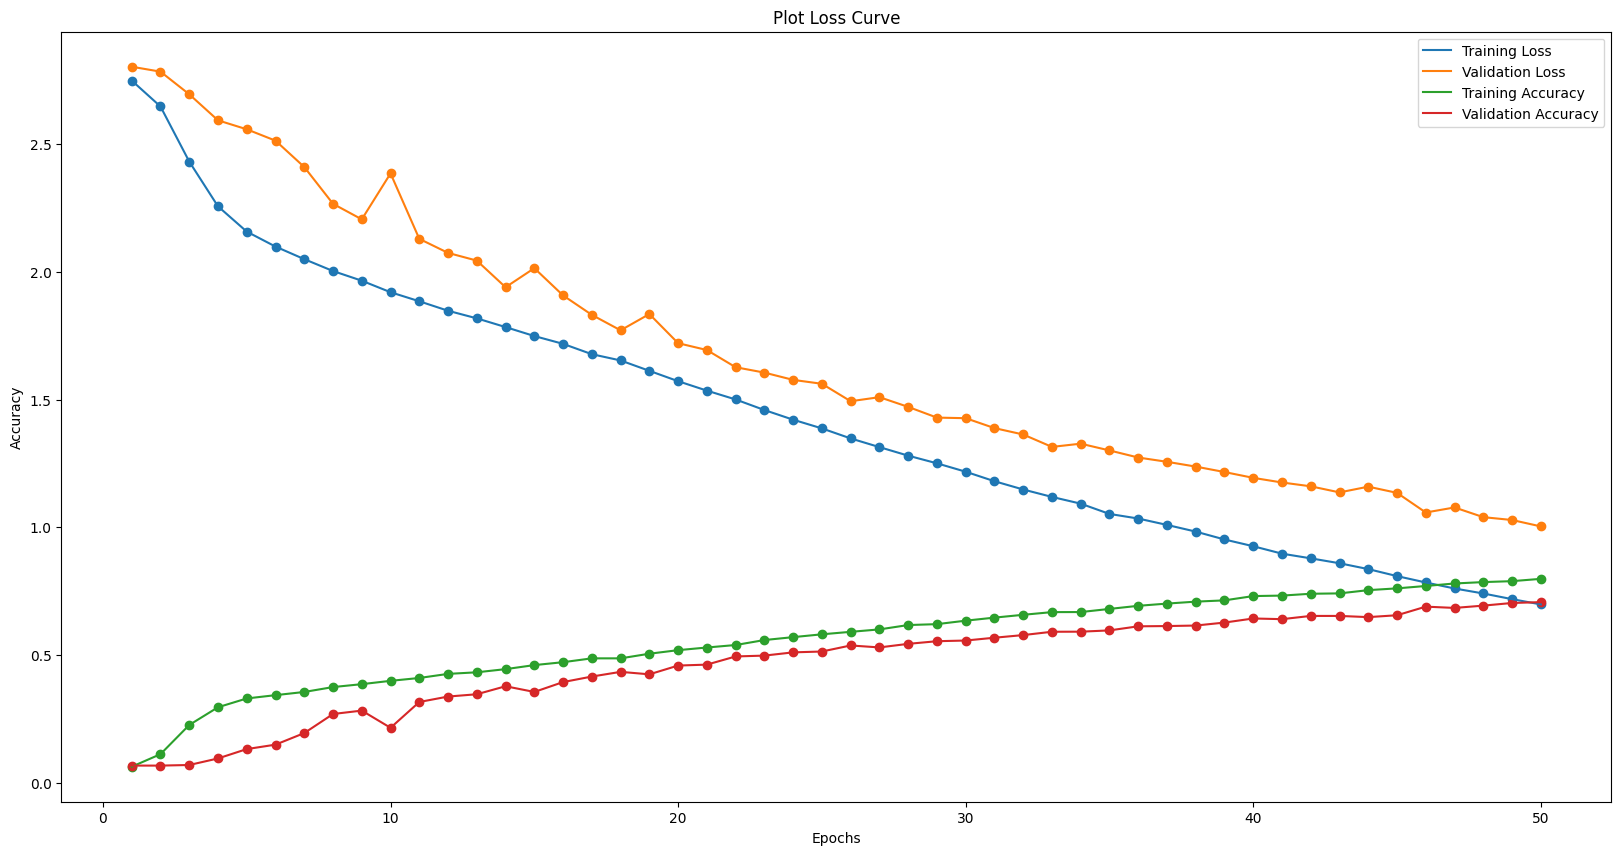

In [79]:
plot_loss_curve(train_history.history)

<H1>Data Augmentation</H1>

In [71]:
IMG_SIZE = (37, 37, 1)

In [72]:
def data_augmentation(x_train):
    imageArr = []
    for images in x_train:
        images = images.reshape(37, 37, 1)
        image = tf.image.random_flip_left_right(images)
        image = tf.image.resize_with_crop_or_pad(
            image, IMG_SIZE[0] + 4, IMG_SIZE[1])
        image = tf.image.random_crop(
            image, size=IMG_SIZE
        )
        imageArr.append(tf.reshape(image, (37, 37)))
    return np.array(imageArr)

In [73]:
x_train_aug = np.copy(X_train)

In [74]:
x_train_aug = data_augmentation(x_train_aug)

In [75]:
class_labels = {0: 'Bean', 1: 'Bitter_Gourd', 2: 'Bottle_Gourd', 3: 'Brinjal', 4: 'Broccoli', 5: 'Cabbage', 6: 'Capsicum', 7: 'Carrot', 8: 'Cauliflower', 9: 'Cucumber', 10: 'Papaya', 11: 'Potato', 12: 'Pumpkin', 13: 'Radish', 14: 'Tomato'}

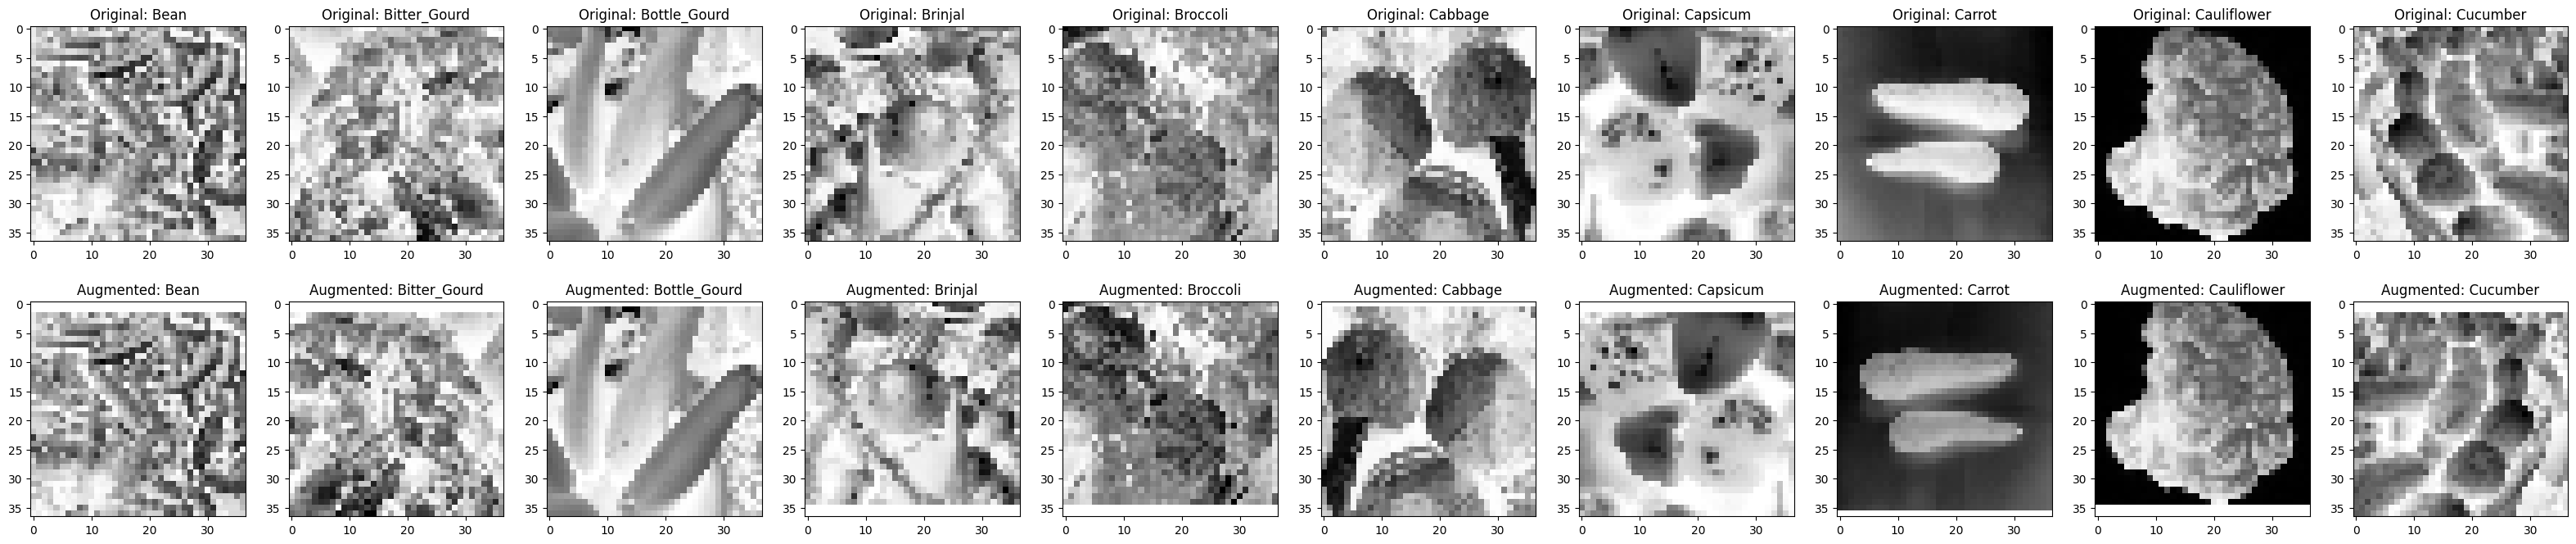

In [76]:
fig, ax = plt.subplots(2, 10, figsize=(40, 8))
for idx in range(20):
    subplot = ax.ravel()[idx]
    y_label = np.argmax(y_train, axis=1)
    if idx >= 10:
        subplot.set_title(f"Augmented: {class_labels[idx % 10]}")
        subplot.imshow(x_train_aug[y_label == idx % 10][0], cmap='Greys')
    else:
        subplot.set_title(f"Original: {class_labels[idx % 10]}")
        subplot.imshow(X_train[y_label == idx % 10][0], cmap='Greys')
    subplot.axis("on")
plt.show()

In [80]:
x_train_aug.shape

(9043, 37, 37)

In [77]:
# # fix random seed for reproducibility
# from tensorflow.keras.layers import BatchNormalization

# seed = 88
# np.random.seed(seed)
# # load data
# num_classes = y_test.shape[1]
# # build the model
# # create model
# model = Sequential()

# model.add(Conv2D(30, (5, 5), input_shape=(37, 37, 1), activation='sigmoid'))
# model.add(MaxPooling2D(pool_size=(2, 2)))

# model.add(Conv2D(30, (3, 3), activation='sigmoid'))
# model.add(MaxPooling2D(pool_size=(2, 2)))

# model.add(Dropout(0.4))
# model.add(Flatten())

# model.add(Dense(128, activation='sigmoid'))

# model.add(BatchNormalization())
# model.add(Dense(50, activation='sigmoid'))

# model.add(Dense(num_classes, activation='sigmoid'))

# # Compile modelZ
# model.compile(loss='binary_crossentropy',
#  optimizer='adam', metrics=['accuracy'])

# model.summary()
# monitor_val_acc = EarlyStopping(monitor = 'val_accuracy', patience = 10, verbose=0)
# monitor_val_loss = EarlyStopping(monitor='val_loss', patience=10, verbose=0)
# # Fit the model
# train_history = model.fit(X_train, y_train, validation_data=(X_validate, y_validate), epochs=100, batch_size=200, verbose=1, callbacks=[monitor_val_acc,monitor_val_loss])
# # Final evaluation of the model
# scores = model.evaluate(X_test, y_test, verbose=0)
# print("CNN Error: %.2f%%" % (100-scores[1]*100))